Saturated liquid density = 852.8352820293276


Text(0, 0.5, 'Mass Flow Rate [kg/s]')

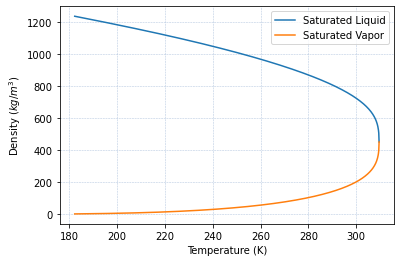

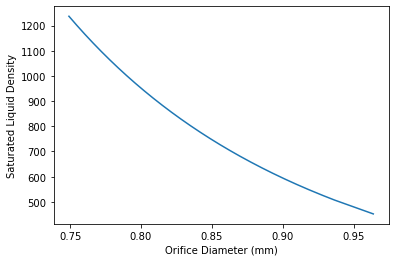

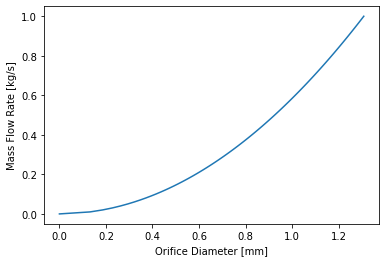

In [1]:
import numpy as np
import CoolProp.CoolProp as CP
import matplotlib.pyplot as plt
import math

# Define fluid
fluid = 'NitrousOxide'

# Define temperature range in Kelvin
T_min = CP.PropsSI(fluid, 'Tmin')
T_max = CP.PropsSI(fluid, 'Tcrit')
temps = np.linspace(T_min, T_max, int(1e3))

liquid_density = []
vapor_density = []
sat_pres = []
        
# Calculate densities and pressures at each temperature
# Q = Molar vapor quality
for T in temps:
    ld = CP.PropsSI('D', 'T', T, 'Q', 0, fluid) # saturated liquid density
    vd = CP.PropsSI('D','T',T,'Q',1,fluid) # saturated vapor density
    psat = CP.PropsSI('P','T',T,'Q',0,fluid)/1e5 # saturation pressure
            
    liquid_density.append(ld)
    vapor_density.append(vd)
    sat_pres.append(psat)
            
plt.figure()
plt.plot(temps, liquid_density, label = 'Saturated Liquid')
plt.plot(temps, vapor_density, label = 'Saturated Vapor')
# plt.title("Nitrous Oxide Density vs Temperature")
plt.xlabel("Temperature (K)")
plt.ylabel(r"Density ($kg/m^3$)")
plt.legend()
plt.grid(visible=True, which='both', axis='both', color='lightsteelblue', linestyle='--', linewidth=0.5)

# Calculate SPI orifice sizes
# Using saturated liquid density

m_dot_des = 0.39501 # Desired nitrous mass flow rate [kg/s]

Cd = 0.65 # Discharge coefficient
delta_P = 3e6 # Pressure drop across injector 50bar to 20bar

A_SPI = []
d_SPI = []
n = 16 # number of orifices

for i in range(1000):

    a = m_dot_des/(Cd * math.sqrt(2 * liquid_density[i] * delta_P)) # Total orifice area [m]
    a_or = a/n # single orifice area [m]
    d_or = 2 * 1000 * math.sqrt(a_or/math.pi) # [mm]
    
    A_SPI.append(a)
    d_SPI.append(d_or)

plt.figure()
plt.plot(d_SPI, liquid_density)
# plt.title("Orifice Diameter vs Nitrous Density (SPI)")
plt.xlabel("Orifice Diameter (mm)")
plt.ylabel("Saturated Liquid Density")

# Find saturated liquid density
room_temp = 283 # Assuming 10C as tanks are stored outside

index = min(range(len(temps)), key=lambda i: abs(temps[i]-room_temp))
ld_room = liquid_density[index]
print(f"Saturated liquid density = {ld_room}")

# Set a range of mass flow rates
m_dot = np.linspace(0,1, num = 100)

A_SPI2 = []
d_SPI2 = []

for i in range(len(m_dot)):
    a = m_dot[i]/(Cd * math.sqrt(2 * ld_room * delta_P)) # Total orifice area [m]
    a_or = a/n # single orifice area [m]
    d_or = 2 * 1000 * math.sqrt(a_or/math.pi) # [mm]
    
    A_SPI2.append(a)
    d_SPI2.append(d_or)

plt.figure()
plt.plot(d_SPI2, m_dot)
#plt.title("Orifice Diameter vs Mass Flow Rate (SPI)")
plt.xlabel("Orifice Diameter [mm]")
plt.ylabel("Mass Flow Rate [kg/s]")


Text(0, 0.5, 'Mass Flow Rate (kg/s)')

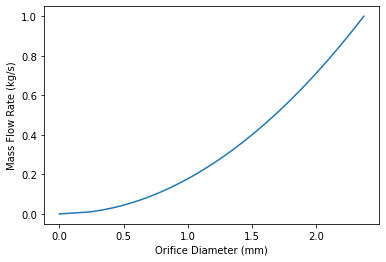

In [2]:
# HEM Calcs

T1 = 283 # Upstream temperature [K]
P2 = 2e6 # Combustion chamber pressure [Pa]

# Find upstream enthalpy and entropy
h1 = CP.PropsSI('H','T', T1, 'Q', 0, fluid) 
s1 = CP.PropsSI('S', 'T', T1, 'Q', 0, fluid)

# Downstream enthalpy of liquid using upstream values
h2 = CP.PropsSI('H', 'P', P2, 'S', s1, fluid)
rho2 = CP.PropsSI('D', 'P', P2, 'S', s1, fluid)

# Orifice diameter for various mass flow rates
d_HEM = []

for i in range(len(m_dot)):
    a = m_dot[i]/(Cd * rho2 * math.sqrt(2*(h1 - h2))) 
    a_or = a/n
    d_or = 2 * 1000 * math.sqrt(a_or/math.pi) # orifice diameter [mm]

    d_HEM.append(d_or)
    
plt.figure()
plt.plot(d_HEM, m_dot)
plt.xlabel("Orifice Diameter (mm)")
plt.ylabel("Mass Flow Rate (kg/s)")
#plt.title("Orifice Diameter vs Mass Flow Rate (HEM)")



Nitrous orifice diameter = 0.9913009855472509
1.2288051457912144


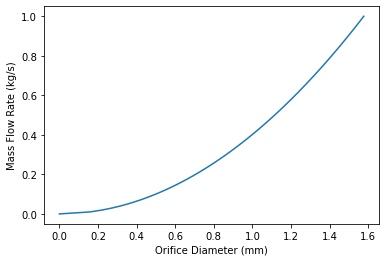

In [3]:
# DYER Model

Pv = CP.PropsSI('P', 'T', T1, 'Q', 1, fluid) # Saturated vapor pressure [Pa] CHECK

bubble_t = math.sqrt(3/2 * ld_room / (Pv - P2)) # Characteristic bubble growth time

# The liquid residence time depends on the injector hole length (L) which will depend on the impingement angle.

L = 5.41431250 * 1e-3 # Injector hole length [m]
res_t = L * math.sqrt(ld_room / (2 * delta_P))

# Kappa is proportional to the ratio of the two above values but the constant is unknown

P1 = 5e6 # Upstream pressure [Pa]
kappa = math.sqrt((P1 - P2) / (Pv - P2))

time_ratio = bubble_t / res_t
const = kappa / time_ratio 

# Assuming the DYER mass flow rate should equal the desired mass flow rate, calculate orifice sizes

d_DYER = []

for i in range(len(m_dot)):
    a = m_dot[i] * (1 + kappa) / (Cd * (kappa * math.sqrt(2 * ld_room * delta_P) + rho2 * math.sqrt(2 * (h1 - h2))))
    a_or = a/n
    d_or = 2 * 1000 * math.sqrt(a_or/math.pi) # orifice diameter [mm]
    
    d_DYER.append(d_or)
    
plt.figure()
plt.plot(d_DYER, m_dot)
#plt.title("Orifice Diameter vs Mass Flow Rate (DYER)")
plt.xlabel("Orifice Diameter (mm)")
plt.ylabel("Mass Flow Rate (kg/s)")
#plt.grid()

# Orifice diameter for desired mass flow rate

A_DYER = m_dot_des * (1 + kappa) / (Cd * (kappa * math.sqrt(2 * ld_room * delta_P) + rho2 * math.sqrt(2 * (h1 - h2))))
A_or_DYER = A_DYER/n
d_DYER_des = 2 * 1000 * math.sqrt(A_or_DYER/math.pi)

print(f"Nitrous orifice diameter = {d_DYER_des}")




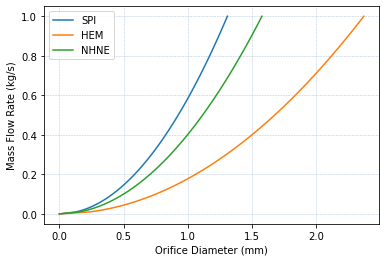

In [4]:
# Plotting all three together

plt.figure()
plt.plot(d_SPI2, m_dot, label = "SPI")
plt.plot(d_HEM, m_dot, label = "HEM")
plt.plot(d_DYER, m_dot, label = 'NHNE')
plt.legend()
#plt.title("Orifice Diameter vs Mass Flow Rate")
plt.xlabel("Orifice Diameter (mm)")
plt.ylabel("Mass Flow Rate (kg/s)")
plt.grid(visible=True, which='both', axis='both', color='lightsteelblue', linestyle='--', linewidth=0.5)

In [5]:
# IPA Orifices

# SPI model

n = 16 # Number of orifices

m_dotF = 0.158 # IPA mass flow rate [kg/s]
delta_PF = 1e6 # IPA pressure drop (30 bar feed pressure to 20 bar chamber pressure)
rho_F = 786 # IPA density [kg/m3]

A_F = m_dotF / (Cd * math.sqrt(2 * rho_F * delta_PF))
A_orF = A_F / n
d_orF = 2 * 1000 * math.sqrt(A_orF / math.pi) # IPA orifice diameter [mm]

print(f"IPA orifice diameter = {round(d_orF,3)} mm")


IPA orifice diameter = 0.698 mm


In [8]:
# Orifice Angles

# Cant angle is the sum of the impingment angles and should be close to but below 41deg

vF = Cd * math.sqrt(2 * delta_PF / rho_F)
vO = Cd * math.sqrt(2 * delta_P / ld_room)

m_dot_or_O = m_dot_des / n # Oxidiser mass flow rate through one orifice [kg/s]
m_dot_or_F = m_dotF / n # Fuel ""

d_O = np.linspace(5, 11, num = 100) # Set up many values for oxidiser impingement angle
d_F = []

for i in range(len(d_O)):
    d_frad = math.asin(m_dot_or_O * vO * math.sin(math.radians(d_O[i])) / (m_dot_or_F * vF))
    d_f = math.degrees(d_frad)
    
    d_F.append(d_f)

cant = d_O + d_F

des = 8 # Index for cant angle I want

print(f" Oxidiser delta = {round(d_O[des],3)}, Fuel delta = {round(d_F[des],3)}, Cant = {round(cant[des],3)}") # Choose index that gives desired cant

# Oxidiser initial angles

p_imp = 35

aO = np.linspace(1, 90, num = 10000)
bO = []

# Calculate bO
for i in range(len(aO)):
    b = p_imp - aO[i]
    bO.append(b)
    
deltaO = []

for i in range(len(aO)):
    dO = math.atan((math.sin(math.radians(aO[i])) - math.sin(math.radians(bO[i]))) / (math.cos(math.radians(aO[i])) + math.cos(math.radians(bO[i]))))
    deltaO.append(math.degrees(dO))

ind = min(range(len(deltaO)), key=lambda i: abs(deltaO[i]-d_O[des]))

print(f"aO = {round(aO[ind],3)}, bO = {round(bO[ind],3)}, dO = {round(deltaO[ind],3)}")

# Fuel initial angles
aF = np.linspace(1, 90, num = 10000)
bF = []

# Calculate bF
for i in range(len(aF)):
    b = p_imp - aF[i]
    bF.append(b)

deltaF = []

for i in range(len(aF)):
    dF = math.atan((math.sin(math.radians(aF[i])) - math.sin(math.radians(bF[i]))) / (math.cos(math.radians(aF[i])) + math.cos(math.radians(bF[i]))))
    deltaF.append(math.degrees(dF))

indF = min(range(len(deltaF)), key=lambda i: abs(deltaF[i]-d_F[des]))

print(f"aF = {round(aF[indF],3)}, bF = {round(bF[indF],3)}, dF = {round(deltaF[indF],3)}")

 Oxidiser delta = 5.485, Fuel delta = 23.412, Cant = 28.897
aO = 22.985, bO = 12.015, dO = 5.485
aF = 40.912, bF = -5.912, dF = 23.412


In [9]:
# Orifice Spacing
l_d = 5 # recommended freestream length over diameter

# d_DYER_des, d_orF in mm

LO = l_d * d_DYER_des
LF = l_d * d_orF
#print(f"Freestream O = {LO}, Freestream F = {LF}")

thick = 5 # Injector plate thickness [mm]

# Oxidiser spacing
xO1 = LO / math.tan(math.radians(90 - aO[ind]))
xO2 = LO / math.tan(math.radians(90 - bO[ind]))

ox_mm = xO1 + xO2
print(f"Lower oxidiser spacing = {round(ox_mm,3)} mm")

yO1 = thick / math.tan(math.radians(90 - aO[ind]))
yO2 = thick / math.tan(math.radians(90 - bO[ind]))

ox_space = ox_mm + yO1 + yO2
print(f"Upper oxidiser spacing = {round(ox_space,3)} mm")

# Fuel spacing - will change as will most likely be rotated
xF1 = LF / math.tan(math.radians(90 - aF[indF]))
xF2 = LF / math.tan(math.radians(90 - bF[indF]))

fx_mm = xF1 + xF2
print(f"Lower fuel spacing = {round(fx_mm,3)} mm")

yF1 = thick / math.tan(math.radians(90 - aF[indF]))
yF2 = thick / math.tan(math.radians(90 - bF[indF]))

f_space = fx_mm + yF1 + yF2
print(f"Upper fuel spacing = {round(f_space,3)} mm")


Lower oxidiser spacing = 3.157 mm
Upper oxidiser spacing = 6.342 mm
Lower fuel spacing = 2.665 mm
Upper fuel spacing = 6.48 mm
